In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [01:24<00:00, 285.03it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
                                                                 conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, None, None, 1 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_preact_bn (BatchN (None, None, None, 1 4096        conv4_block10_out[0][0]          
__________________________________________________________________________________________________
conv4_block11_preact_relu (Acti (None, None, None, 1 0           conv4_block11_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block11_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

__________________________________________________________________________________________________
conv4_block18_preact_bn (BatchN (None, None, None, 1 4096        conv4_block17_out[0][0]          
__________________________________________________________________________________________________
conv4_block18_preact_relu (Acti (None, None, None, 1 0           conv4_block18_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block18_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block18_1_bn (BatchNormal (None, None, None, 2 1024        conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, None, None, 2 0           conv4_block18_1_bn[0][0]         
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

                                                                 conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-06 12:30:09.507703
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 3:42 - loss: 8.8601 - accuracy: 0.04 - ETA: 2:51 - loss: 9.5920 - accuracy: 0.07 - ETA: 2:38 - loss: 11.0004 - accuracy: 0.085 - ETA: 2:29 - loss: 11.8383 - accuracy: 0.093 - ETA: 2:23 - loss: 11.2209 - accuracy: 0.100 - ETA: 2:20 - loss: 10.2421 - accuracy: 0.112 - ETA: 2:15 - loss: 9.3599 - accuracy: 0.125 - ETA: 2:12 - loss: 8.7283 - accuracy: 0.12 - ETA: 2:09 - loss: 8.1406 - accuracy: 0.13 - ETA: 2:07 - loss: 7.6365 - accuracy: 0.15 - ETA: 2:05 - loss: 7.2451 - accuracy: 0.16 - ETA: 2:03 - loss: 6.9222 - accuracy: 0.16 - ETA: 2:01 - loss: 6.6137 - accuracy: 0.17 - ETA: 2:00 - loss: 6.3461 - accuracy: 0.18 - ETA: 1:59 - loss: 6.1022 - accuracy: 0.20 - ETA: 1:58 - loss: 5.9141 - accuracy: 0.20 - ETA: 1:57 - loss: 5.7429 - accuracy: 0.21 - ETA: 1:56 - loss: 5.5855 - accuracy: 0.21 - ETA: 1:55 - loss: 5.4345 - accuracy: 0.22 - ETA: 1:54 - loss: 5.

19312/19312 [==============================] - ETA: 1:52 - loss: 1.2528 - accuracy: 0.64 - ETA: 1:48 - loss: 1.0407 - accuracy: 0.69 - ETA: 1:45 - loss: 1.0225 - accuracy: 0.70 - ETA: 1:45 - loss: 1.0682 - accuracy: 0.68 - ETA: 1:45 - loss: 1.0387 - accuracy: 0.70 - ETA: 1:45 - loss: 1.0136 - accuracy: 0.70 - ETA: 1:46 - loss: 0.9983 - accuracy: 0.71 - ETA: 1:46 - loss: 1.0093 - accuracy: 0.71 - ETA: 1:44 - loss: 1.0143 - accuracy: 0.71 - ETA: 1:43 - loss: 1.0255 - accuracy: 0.71 - ETA: 1:43 - loss: 1.0138 - accuracy: 0.71 - ETA: 1:42 - loss: 1.0149 - accuracy: 0.72 - ETA: 1:41 - loss: 1.0224 - accuracy: 0.72 - ETA: 1:40 - loss: 1.0174 - accuracy: 0.72 - ETA: 1:39 - loss: 1.0143 - accuracy: 0.72 - ETA: 1:38 - loss: 1.0237 - accuracy: 0.71 - ETA: 1:37 - loss: 1.0169 - accuracy: 0.72 - ETA: 1:36 - loss: 1.0181 - accuracy: 0.71 - ETA: 1:36 - loss: 1.0212 - accuracy: 0.71 - ETA: 1:35 - loss: 1.0180 - accuracy: 0.71 - ETA: 1:34 - loss: 1.0216 - accuracy: 0.71 - ETA: 1:33 - loss: 1.0287 - ac

19312/19312 [==============================] - ETA: 1:37 - loss: 0.6258 - accuracy: 0.84 - ETA: 1:39 - loss: 0.5793 - accuracy: 0.86 - ETA: 1:42 - loss: 0.5561 - accuracy: 0.85 - ETA: 1:39 - loss: 0.5542 - accuracy: 0.84 - ETA: 1:38 - loss: 0.5252 - accuracy: 0.86 - ETA: 1:38 - loss: 0.5267 - accuracy: 0.86 - ETA: 1:38 - loss: 0.5522 - accuracy: 0.85 - ETA: 1:38 - loss: 0.5397 - accuracy: 0.85 - ETA: 1:38 - loss: 0.5458 - accuracy: 0.85 - ETA: 1:37 - loss: 0.5484 - accuracy: 0.84 - ETA: 1:36 - loss: 0.5591 - accuracy: 0.84 - ETA: 1:36 - loss: 0.5510 - accuracy: 0.84 - ETA: 1:35 - loss: 0.5544 - accuracy: 0.84 - ETA: 1:36 - loss: 0.5529 - accuracy: 0.84 - ETA: 1:36 - loss: 0.5540 - accuracy: 0.84 - ETA: 1:35 - loss: 0.5416 - accuracy: 0.85 - ETA: 1:35 - loss: 0.5395 - accuracy: 0.85 - ETA: 1:34 - loss: 0.5475 - accuracy: 0.84 - ETA: 1:33 - loss: 0.5477 - accuracy: 0.85 - ETA: 1:33 - loss: 0.5474 - accuracy: 0.85 - ETA: 1:32 - loss: 0.5434 - accuracy: 0.85 - ETA: 1:31 - loss: 0.5511 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 0.3182 - accuracy: 0.89 - ETA: 1:46 - loss: 0.2656 - accuracy: 0.91 - ETA: 1:44 - loss: 0.2709 - accuracy: 0.91 - ETA: 1:43 - loss: 0.2771 - accuracy: 0.91 - ETA: 1:42 - loss: 0.2799 - accuracy: 0.91 - ETA: 1:41 - loss: 0.2879 - accuracy: 0.90 - ETA: 1:41 - loss: 0.2814 - accuracy: 0.91 - ETA: 1:41 - loss: 0.2868 - accuracy: 0.91 - ETA: 1:40 - loss: 0.2906 - accuracy: 0.91 - ETA: 1:39 - loss: 0.2921 - accuracy: 0.91 - ETA: 1:38 - loss: 0.3008 - accuracy: 0.90 - ETA: 1:38 - loss: 0.3072 - accuracy: 0.90 - ETA: 1:37 - loss: 0.3156 - accuracy: 0.90 - ETA: 1:36 - loss: 0.3168 - accuracy: 0.90 - ETA: 1:36 - loss: 0.3159 - accuracy: 0.90 - ETA: 1:35 - loss: 0.3113 - accuracy: 0.90 - ETA: 1:34 - loss: 0.3050 - accuracy: 0.90 - ETA: 1:33 - loss: 0.3080 - accuracy: 0.90 - ETA: 1:32 - loss: 0.3112 - accuracy: 0.91 - ETA: 1:32 - loss: 0.3097 - accuracy: 0.91 - ETA: 1:31 - loss: 0.3062 - accuracy: 0.91 - ETA: 1:31 - loss: 0.3046 - ac

19312/19312 [==============================] - ETA: 1:38 - loss: 0.2382 - accuracy: 0.92 - ETA: 1:38 - loss: 0.2104 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1754 - accuracy: 0.95 - ETA: 1:40 - loss: 0.1640 - accuracy: 0.95 - ETA: 1:39 - loss: 0.1761 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1904 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1947 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1935 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1959 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1927 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1926 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1966 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1942 - accuracy: 0.95 - ETA: 1:35 - loss: 0.1959 - accuracy: 0.95 - ETA: 1:35 - loss: 0.1959 - accuracy: 0.95 - ETA: 1:34 - loss: 0.1913 - accuracy: 0.95 - ETA: 1:34 - loss: 0.1919 - accuracy: 0.95 - ETA: 1:33 - loss: 0.1919 - accuracy: 0.95 - ETA: 1:32 - loss: 0.1900 - accuracy: 0.95 - ETA: 1:32 - loss: 0.1907 - accuracy: 0.95 - ETA: 1:32 - loss: 0.1926 - accuracy: 0.95 - ETA: 1:31 - loss: 0.1928 - ac

19312/19312 [==============================] - ETA: 1:47 - loss: 0.1117 - accuracy: 0.95 - ETA: 1:42 - loss: 0.1116 - accuracy: 0.95 - ETA: 1:41 - loss: 0.1450 - accuracy: 0.95 - ETA: 1:40 - loss: 0.1526 - accuracy: 0.95 - ETA: 1:39 - loss: 0.1425 - accuracy: 0.95 - ETA: 1:38 - loss: 0.1361 - accuracy: 0.96 - ETA: 1:38 - loss: 0.1317 - accuracy: 0.96 - ETA: 1:38 - loss: 0.1327 - accuracy: 0.96 - ETA: 1:38 - loss: 0.1318 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1329 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1299 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1264 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1284 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1271 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1307 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1286 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1311 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1316 - accuracy: 0.96 - ETA: 1:34 - loss: 0.1334 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1348 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1356 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1354 - ac

19312/19312 [==============================] - ETA: 1:45 - loss: 0.0538 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0601 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0564 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0638 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0694 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0677 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0671 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0717 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0750 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0721 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0815 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0876 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0855 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0853 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0871 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0860 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0851 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0837 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0862 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0851 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0870 - accuracy: 0.97 - ETA: 1:32 - loss: 0.0875 - ac

19312/19312 [==============================] - ETA: 1:47 - loss: 0.1015 - accuracy: 0.96 - ETA: 1:46 - loss: 0.0910 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0724 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0749 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0729 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0682 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0668 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0729 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0725 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0719 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0710 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0694 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0693 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0717 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0736 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0719 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0717 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0713 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0736 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0715 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0711 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0711 - ac

19312/19312 [==============================] - ETA: 2:10 - loss: 0.0422 - accuracy: 1.00 - ETA: 2:02 - loss: 0.0496 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0581 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0549 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0547 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0532 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0526 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0516 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0577 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0549 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0579 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0551 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0553 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0553 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0556 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0563 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0565 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0618 - ac

19312/19312 [==============================] - ETA: 2:01 - loss: 0.0961 - accuracy: 0.96 - ETA: 1:54 - loss: 0.0708 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0606 - accuracy: 0.97 - ETA: 1:48 - loss: 0.0582 - accuracy: 0.97 - ETA: 1:48 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0637 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0674 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0631 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0637 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0625 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0605 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0608 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0598 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0587 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0564 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0563 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0558 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0542 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0538 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0303 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0357 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0391 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0437 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0407 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0399 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0373 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0381 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0391 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0409 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0420 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0419 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0393 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0386 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0396 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0388 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0377 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0376 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0381 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0374 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0366 - ac

19312/19312 [==============================] - ETA: 1:54 - loss: 0.0433 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0368 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0284 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0385 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0352 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0359 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0343 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0331 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0313 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0293 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0301 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0317 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0310 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0302 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0302 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0310 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0298 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0287 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0287 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0283 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0284 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0289 - ac

19312/19312 [==============================] - ETA: 1:55 - loss: 0.0099 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0155 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0191 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0229 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0216 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0229 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0227 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0231 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0284 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0267 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0264 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0264 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0256 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0249 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0244 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0248 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0251 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0245 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0253 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0257 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0268 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0263 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0137 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0135 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0190 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0208 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0340 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0315 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0313 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0301 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0305 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0305 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0297 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0287 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0277 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0270 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0258 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0263 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0252 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0248 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0243 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0238 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0235 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0244 - ac

19312/19312 [==============================] - ETA: 1:59 - loss: 0.0154 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0158 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0137 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0131 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0131 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0152 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0141 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0137 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0141 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0140 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0158 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0165 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0162 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0159 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0160 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0158 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0166 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0172 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0171 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0166 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0170 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0169 - ac

19312/19312 [==============================] - ETA: 3:30 - loss: 0.0178 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0226 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0251 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0213 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0191 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0179 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0169 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0173 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0187 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0191 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0194 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0187 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0185 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0191 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0201 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0211 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0208 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0202 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0196 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0199 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0205 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0201 - ac

19312/19312 [==============================] - ETA: 3:22 - loss: 0.0325 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0224 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0268 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0249 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0244 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0227 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0246 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0256 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0241 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0231 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0226 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0238 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0224 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0215 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0209 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0207 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0206 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0204 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0206 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0207 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0204 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0204 - ac

19312/19312 [==============================] - ETA: 3:26 - loss: 0.0062 - accuracy: 1.00 - ETA: 3:33 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:30 - loss: 0.0085 - accuracy: 1.00 - ETA: 3:28 - loss: 0.0127 - accuracy: 0.99 - ETA: 3:27 - loss: 0.0138 - accuracy: 0.99 - ETA: 3:25 - loss: 0.0137 - accuracy: 0.99 - ETA: 3:24 - loss: 0.0134 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0149 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0169 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0163 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0159 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0156 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0157 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0153 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0146 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0151 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0149 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0147 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0146 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0144 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0150 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0158 - ac

19312/19312 [==============================] - ETA: 3:25 - loss: 0.0123 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0133 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0149 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0174 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0158 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0154 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0168 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0168 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0174 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0167 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0169 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0171 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0168 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0168 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0168 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0173 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0169 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0178 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0180 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0182 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0177 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0186 - ac

19312/19312 [==============================] - ETA: 3:02 - loss: 0.0157 - accuracy: 1.00 - ETA: 3:20 - loss: 0.0117 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0130 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0314 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0272 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0248 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0245 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0230 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0242 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0226 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0222 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0207 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0201 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0197 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0200 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0196 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0198 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0192 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0185 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0183 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0180 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0175 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 0.0111 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0179 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0133 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0138 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0182 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0164 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0183 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0172 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0161 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0154 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0150 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0142 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0149 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0154 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0158 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0153 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0156 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0151 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0146 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0144 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0144 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0143 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 0.0049 - accuracy: 1.00 - ETA: 3:23 - loss: 0.0062 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0182 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0150 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0216 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0194 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0212 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0191 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0183 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0174 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0162 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0167 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0164 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0157 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0159 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0151 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0147 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0143 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0147 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0145 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0144 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0140 - ac

19312/19312 [==============================] - ETA: 3:08 - loss: 0.0237 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0213 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0153 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0127 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0117 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0131 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0123 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0125 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0120 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0114 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0110 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0116 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0113 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0120 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0116 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0113 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0110 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0112 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0110 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0111 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0112 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0109 - ac

19312/19312 [==============================] - ETA: 3:30 - loss: 0.0029 - accuracy: 1.00 - ETA: 3:24 - loss: 0.0042 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0075 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0092 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0092 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0092 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0086 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0093 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0103 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0106 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0103 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0107 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0113 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0114 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0111 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0108 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0106 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0105 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0103 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0103 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0109 - ac

19312/19312 [==============================] - ETA: 3:29 - loss: 0.0039 - accuracy: 1.00 - ETA: 3:30 - loss: 0.0044 - accuracy: 1.00 - ETA: 3:26 - loss: 0.0044 - accuracy: 1.00 - ETA: 3:25 - loss: 0.0049 - accuracy: 1.00 - ETA: 3:22 - loss: 0.0051 - accuracy: 1.00 - ETA: 3:21 - loss: 0.0057 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0063 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0067 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0069 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0070 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0070 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0071 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0071 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0070 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0068 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0073 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0072 - ac

19312/19312 [==============================] - ETA: 3:42 - loss: 0.0054 - accuracy: 1.00 - ETA: 3:30 - loss: 0.0052 - accuracy: 1.00 - ETA: 3:22 - loss: 0.0054 - accuracy: 1.00 - ETA: 3:20 - loss: 0.0049 - accuracy: 1.00 - ETA: 3:18 - loss: 0.0050 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0059 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0068 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0068 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0076 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0074 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0101 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0101 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0114 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0112 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0107 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0104 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0095 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0105 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0103 - ac

19312/19312 [==============================] - ETA: 3:18 - loss: 0.0044 - accuracy: 1.00 - ETA: 3:18 - loss: 0.0048 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0064 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0066 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0063 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0061 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0064 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0078 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0078 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0081 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0086 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0093 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0101 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0098 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0097 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0093 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0089 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0092 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0095 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0092 - ac

19312/19312 [==============================] - ETA: 3:01 - loss: 0.0044 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0054 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0075 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0069 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0068 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0095 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0091 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0097 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0092 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0090 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0108 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0095 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0092 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0105 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0101 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0100 - accuracy: 0.99 - ETA: 2:48 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0106 - accuracy: 0.99 - ETA: 2:46 - loss: 0.0102 - ac

19312/19312 [==============================] - ETA: 3:12 - loss: 0.0037 - accuracy: 1.00 - ETA: 3:17 - loss: 0.0026 - accuracy: 1.00 - ETA: 3:17 - loss: 0.0064 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0054 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0067 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0075 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0083 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0078 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0075 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0070 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0069 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0072 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0069 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0071 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0068 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0076 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0074 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0072 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0070 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0068 - ac

19312/19312 [==============================] - ETA: 3:01 - loss: 0.0044 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0070 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0064 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0067 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0057 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0092 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0090 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0083 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0096 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0102 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0096 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0094 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0092 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0088 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0087 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0099 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0098 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0095 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0092 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0089 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0086 - ac

19312/19312 [==============================] - ETA: 3:06 - loss: 0.0140 - accuracy: 0.99 - ETA: 3:26 - loss: 0.0077 - accuracy: 0.99 - ETA: 3:26 - loss: 0.0064 - accuracy: 0.99 - ETA: 3:25 - loss: 0.0064 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0084 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0080 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0075 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0084 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0126 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0120 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0114 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0108 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0102 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0098 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0094 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0097 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0102 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0098 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0100 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0100 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0098 - ac

19312/19312 [==============================] - ETA: 1:58 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0079 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0078 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0072 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0069 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:53 - loss: 0.0072 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0069 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0078 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0071 - ac

19312/19312 [==============================] - ETA: 1:48 - loss: 0.0082 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0065 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0112 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0105 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0099 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0091 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0090 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0091 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0088 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0080 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0092 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0087 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0083 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0080 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0070 - ac

19312/19312 [==============================] - ETA: 1:56 - loss: 0.0087 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0082 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0064 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0053 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0056 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0053 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0052 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0057 - ac

19312/19312 [==============================] - ETA: 1:54 - loss: 0.0063 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0083 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0118 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0092 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0086 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0063 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0063 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0069 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0064 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0060 - ac

19312/19312 [==============================] - ETA: 2:15 - loss: 0.0067 - accuracy: 1.00 - ETA: 1:58 - loss: 0.0057 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0047 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0042 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0114 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0113 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0105 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0100 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0135 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0133 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0126 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0128 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0123 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0120 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0117 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0112 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0110 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0106 - ac

19312/19312 [==============================] - ETA: 2:05 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0053 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0048 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0048 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0048 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0044 - ac

19312/19312 [==============================] - ETA: 2:00 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0078 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0086 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0084 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0081 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0080 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0081 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0072 - ac

19312/19312 [==============================] - ETA: 1:43 - loss: 0.0047 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0091 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0096 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0082 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0096 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0095 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0095 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0091 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0087 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0082 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0079 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0075 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0064 - ac

19312/19312 [==============================] - ETA: 2:03 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0042 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0041 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0048 - ac

19312/19312 [==============================] - ETA: 1:59 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:54 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0047 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0051 - ac

19312/19312 [==============================] - ETA: 1:47 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0065 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0090 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0095 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0085 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0063 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0061 - ac

19312/19312 [==============================] - ETA: 1:53 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0046 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0057 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0057 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0061 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 7.2781e-04 - accuracy: 1.00 - ETA: 1:47 - loss: 7.4180e-04 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0024 - accuracy: 1.0000   - ETA: 1:47 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0050 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0041 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0063 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0057 - accuracy: 0.99 - ETA: 1:33 - loss:

19312/19312 [==============================] - ETA: 2:00 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:59 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0057 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0057 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0053 - ac

19312/19312 [==============================] - ETA: 2:01 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0031 - ac

19312/19312 [==============================] - ETA: 1:52 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0035 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0032 - ac

19312/19312 [==============================] - ETA: 1:53 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0052 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0079 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0082 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0086 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0081 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0077 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0069 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0060 - ac

19312/19312 [==============================] - ETA: 2:06 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:56 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0041 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0032 - ac

19312/19312 [==============================] - ETA: 1:46 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0031 - ac

19312/19312 [==============================] - ETA: 1:48 - loss: 0.0092 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0051 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0045 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0042 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0041 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0041 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0047 - ac

19312/19312 [==============================] - ETA: 1:55 - loss: 0.0083 - accuracy: 1.00 - ETA: 1:54 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0032 - ac

19312/19312 [==============================] - ETA: 1:58 - loss: 8.9484e-04 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0019 - accuracy: 1.0000   - ETA: 1:47 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0

19312/19312 [==============================] - ETA: 1:56 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:56 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:57 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:56 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0038 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 0.0053 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0031 - ac

19312/19312 [==============================] - ETA: 1:53 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0079 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0069 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0043 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0043 - ac

19312/19312 [==============================] - ETA: 1:46 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0049 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0025 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 0.0014 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0052 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0072 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0071 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0056 - ac

19312/19312 [==============================] - ETA: 1:50 - loss: 0.0071 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0042 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0044 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0039 - ac

19312/19312 [==============================] - ETA: 2:02 - loss: 0.0011 - accuracy: 1.00 - ETA: 1:58 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0043 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0064 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0043 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0042 - ac

19312/19312 [==============================] - ETA: 1:48 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0052 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0046 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0042 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0066 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0064 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0059 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0054 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0043 - ac

19312/19312 [==============================] - ETA: 1:56 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:54 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0025 - ac

19312/19312 [==============================] - ETA: 2:01 - loss: 0.0056 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:33 - loss: 0.0026 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0027 - ac

19312/19312 [==============================] - ETA: 1:55 - loss: 0.0040 - accuracy: 1.00 - ETA: 1:56 - loss: 0.0068 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0054 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0043 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0067 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0060 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0047 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0043 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0044 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0043 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0040 - ac

19312/19312 [==============================] - ETA: 1:45 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0042 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0033 - ac

19312/19312 [==============================] - ETA: 2:11 - loss: 0.0034 - accuracy: 1.00 - ETA: 2:00 - loss: 0.0025 - accuracy: 1.00 - ETA: 2:02 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:02 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:59 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:53 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0028 - ac

19312/19312 [==============================] - ETA: 1:51 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0023 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0028 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0028 - ac

19312/19312 [==============================] - ETA: 1:53 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:54 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0021 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0020 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0020 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0019 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0018 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0024 - ac

19312/19312 [==============================] - ETA: 1:59 - loss: 8.2517e-04 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0106 - accuracy: 0.9961   - ETA: 1:50 - loss: 0.0073 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0093 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0089 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0081 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0074 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0068 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0070 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0065 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0062 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0058 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0053 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0051 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0050 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0048 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0046 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0

19312/19312 [==============================] - ETA: 1:58 - loss: 0.0014 - accuracy: 1.00 - ETA: 1:58 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:53 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0032 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0036 - ac

19312/19312 [==============================] - ETA: 1:49 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0011 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0036 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0032 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0028 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0024 - ac

19312/19312 [==============================] - ETA: 1:50 - loss: 0.0052 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0033 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0029 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:36 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:35 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:34 - loss: 0.0020 - ac

19312/19312 [==============================] - ETA: 1:56 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0058 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0047 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0038 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0024 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0023 - ac

19312/19312 [==============================] - ETA: 1:55 - loss: 0.0014 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0013 - accuracy: 1.00 - ETA: 1:37 - loss: 0.0016 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0017 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0017 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0016 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0016 - ac

19312/19312 [==============================] - ETA: 2:02 - loss: 0.0150 - accuracy: 1.00 - ETA: 1:57 - loss: 0.0084 - accuracy: 1.00 - ETA: 1:55 - loss: 0.0058 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0047 - accuracy: 1.00 - ETA: 1:52 - loss: 0.0039 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0034 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0027 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0026 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0025 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0026 - ac

19312/19312 [==============================] - ETA: 1:52 - loss: 0.0037 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:50 - loss: 0.0021 - accuracy: 1.00 - ETA: 1:49 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0015 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0014 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:41 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:40 - loss: 0.0016 - accuracy: 1.00 - ETA: 1:39 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:38 - loss: 0.0021 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0021 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0020 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0020 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0021 - ac

19312/19312 [==============================] - ETA: 1:53 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0030 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0027 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0026 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0025 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0024 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0023 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0022 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0022 - ac

19312/19312 [==============================] - ETA: 1:45 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0023 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:48 - loss: 0.0022 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:46 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:47 - loss: 0.0020 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:44 - loss: 0.0018 - accuracy: 1.00 - ETA: 1:43 - loss: 0.0019 - accuracy: 1.00 - ETA: 1:42 - loss: 0.0039 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0036 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0040 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0037 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0034 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0035 - ac

19312/19312 [==============================] - ETA: 1:46 - loss: 0.0011 - accuracy: 1.00 - ETA: 1:45 - loss: 0.0076 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0056 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0078 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0072 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0061 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0055 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0049 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0045 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0041 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0038 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0035 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0033 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0031 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0030 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0029 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0029 - ac

19312/19312 [==============================] - ETA: 3:20 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0038 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0027 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0023 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:51 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:49 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:48 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:46 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:45 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:43 - loss: 0.0016 - ac

19312/19312 [==============================] - ETA: 3:17 - loss: 0.0093 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0059 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0044 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0034 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0030 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0028 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0026 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0028 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0028 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0026 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0024 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0023 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0023 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0022 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0025 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0024 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0023 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0023 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0025 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0025 - accuracy: 0.99 - ETA: 2:45 - loss: 0.0024 - accuracy: 0.99 - ETA: 2:44 - loss: 0.0023 - ac

19312/19312 [==============================] - ETA: 3:08 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:14 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:14 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0022 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0020 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0024 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0023 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0022 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0027 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0026 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0025 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0032 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0031 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0030 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0039 - ac

19312/19312 [==============================] - ETA: 3:11 - loss: 0.0023 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:13 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0020 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0019 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0016 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 6.8907e-04 - accuracy: 1.00 - ETA: 3:27 - loss: 5.8410e-04 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0019 - accuracy: 1.0000   - ETA: 3:17 - loss: 0.0030 - accuracy: 1.00 - ETA: 3:16 - loss: 0.0027 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0030 - accuracy: 1.00 - ETA: 3:14 - loss: 0.0027 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0027 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0025 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0023 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0022 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0020 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0018 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:53 - loss:

19312/19312 [==============================] - ETA: 3:17 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:21 - loss: 9.7924e-04 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0011 - accuracy: 1.0000   - ETA: 3:19 - loss: 9.3859e-04 - accuracy: 1.00 - ETA: 3:15 - loss: 8.8759e-04 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0010 - accuracy: 1.0000   - ETA: 3:11 - loss: 0.0018 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0016 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0018 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0017 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0016 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0017 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0017 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0016 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0016 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0015 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0015 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0014 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0015 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0014 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0015 - accuracy: 0.99 - ETA: 2:50

19312/19312 [==============================] - ETA: 3:14 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0010 - accuracy: 1.00 - ETA: 3:10 - loss: 8.1170e-04 - accuracy: 1.00 - ETA: 3:10 - loss: 7.4738e-04 - accuracy: 1.00 - ETA: 3:09 - loss: 7.7485e-04 - accuracy: 1.00 - ETA: 3:09 - loss: 7.1845e-04 - accuracy: 1.00 - ETA: 3:06 - loss: 8.2201e-04 - accuracy: 1.00 - ETA: 3:04 - loss: 9.6973e-04 - accuracy: 1.00 - ETA: 3:02 - loss: 9.5669e-04 - accuracy: 1.00 - ETA: 3:01 - loss: 9.1083e-04 - accuracy: 1.00 - ETA: 3:01 - loss: 8.7640e-04 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0012 - accuracy: 1.0000   - ETA: 3:00 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0021 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0021 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0021 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0020 - accura

19312/19312 [==============================] - ETA: 3:20 - loss: 4.1191e-04 - accuracy: 1.00 - ETA: 3:17 - loss: 9.4278e-04 - accuracy: 1.00 - ETA: 3:22 - loss: 9.7111e-04 - accuracy: 1.00 - ETA: 3:18 - loss: 0.0013 - accuracy: 1.0000   - ETA: 3:17 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:14 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:09 - loss: 0.0031 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0029 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0044 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0042 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0042 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0040 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0041 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0041 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0040 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0039 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0039 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0037 - accuracy: 0.99 - ETA: 2:53 - l

19312/19312 [==============================] - ETA: 3:19 - loss: 7.1878e-04 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0018 - accuracy: 1.0000   - ETA: 3:12 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0022 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0

19312/19312 [==============================] - ETA: 3:10 - loss: 0.0033 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0082 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0056 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0044 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0037 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0038 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0033 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0030 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0028 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0026 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0024 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0024 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0023 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0022 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0022 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0021 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0020 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0020 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0021 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0020 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0020 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0020 - ac

19312/19312 [==============================] - ETA: 3:21 - loss: 5.0179e-04 - accuracy: 1.00 - ETA: 3:18 - loss: 9.1948e-04 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0010 - accuracy: 1.0000   - ETA: 3:10 - loss: 0.0010 - accuracy: 1.00 - ETA: 3:10 - loss: 9.9072e-04 - accuracy: 1.00 - ETA: 3:10 - loss: 9.7508e-04 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0011 - accuracy: 1.0000   - ETA: 3:05 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0010 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0011 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0011 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:48 - loss: 0.0013 - accuracy: 1.00 - ETA: 2:47 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:46 - loss: 0.0014 - accuracy: 1.00 - ETA: 

19312/19312 [==============================] - ETA: 3:22 - loss: 0.0094 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0060 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0043 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0036 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0031 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0032 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0040 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0036 - accuracy: 0.99 - ETA: 3:13 - loss: 0.0036 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0033 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0032 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0032 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0031 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0029 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0029 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0029 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0027 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0026 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0025 - ac

19312/19312 [==============================] - ETA: 3:26 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:31 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:29 - loss: 0.0024 - accuracy: 1.00 - ETA: 3:27 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:25 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0026 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0024 - accuracy: 1.00 - ETA: 3:15 - loss: 0.0023 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0022 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0020 - accuracy: 1.00 - ETA: 3:06 - loss: 0.0019 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0018 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:51 - loss: 0.0016 - ac

19312/19312 [==============================] - ETA: 3:12 - loss: 0.0053 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0028 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0021 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:01 - loss: 0.0016 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:57 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0016 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0017 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0016 - ac

19312/19312 [==============================] - ETA: 3:33 - loss: 0.0558 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0283 - accuracy: 0.99 - ETA: 3:27 - loss: 0.0193 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0152 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0124 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0108 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0093 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0088 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0079 - accuracy: 0.99 - ETA: 3:11 - loss: 0.0072 - accuracy: 0.99 - ETA: 3:10 - loss: 0.0066 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0061 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0057 - accuracy: 0.99 - ETA: 3:06 - loss: 0.0079 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0074 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0070 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0067 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0064 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0061 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0058 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0056 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0054 - ac

19312/19312 [==============================] - ETA: 3:42 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:30 - loss: 8.4857e-04 - accuracy: 1.00 - ETA: 3:23 - loss: 0.0013 - accuracy: 1.0000   - ETA: 3:17 - loss: 0.0017 - accuracy: 1.00 - ETA: 3:17 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:14 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0015 - accuracy: 1.00 - ETA: 3:12 - loss: 0.0014 - accuracy: 1.00 - ETA: 3:10 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:04 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:02 - loss: 0.0011 - accuracy: 1.00 - ETA: 3:00 - loss: 0.0012 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0013 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0013 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0015 - accuracy: 1.00 - ETA: 2:56 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:54 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:52 - loss: 0.0014 - accuracy: 1.00 - ETA: 2:51 - loss: 0.0

19312/19312 [==============================] - ETA: 3:05 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:11 - loss: 8.2996e-04 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0016 - accuracy: 1.0000   - ETA: 3:09 - loss: 0.0013 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0012 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0043 - accuracy: 0.99 - ETA: 3:03 - loss: 0.0056 - accuracy: 0.99 - ETA: 3:04 - loss: 0.0050 - accuracy: 0.99 - ETA: 3:02 - loss: 0.0046 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0042 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0039 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0037 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0035 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0034 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0036 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0034 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0033 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0032 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0031 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0030 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0029 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0

In [21]:
print(history.history)

{'val_loss': [1.3617180194833012, 1.1041281200462456, 0.9835185135316838, 0.9327398257414533, 0.928535130693444, 0.9283316958935568, 0.9148873678026892, 0.9184062403041795, 0.918456641110507, 0.9270483902039353, 0.9246683958204273, 0.9170498443232434, 0.9186490222419806, 0.9397142647240418, 0.9313924811744967, 0.9236706707462264, 0.9363509155401015, 0.9246393762703242, 0.9447596589214043, 0.9453934942819386, 0.9423263107404671, 0.942134283830177, 0.9418799072152266, 0.9198186132053234, 0.9444197324596594, 0.9509662398765684, 0.9601552145627745, 0.9589991424241208, 0.973294967559831, 0.9450972123184568, 0.9651991292837367, 0.9533719067668343, 0.9596891399742185, 0.9699562487702953, 0.9692796922465688, 0.9778146277576975, 0.9720129204428352, 0.9648666820261488, 0.9740647939599851, 0.9679135150928185, 0.9707198642529077, 0.9744063626784275, 0.9738588659850725, 0.9605784457794848, 0.974652566322754, 0.9655225227945067, 0.974549763035789, 0.9770324038136052, 0.9595876552224727, 0.9757450817

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


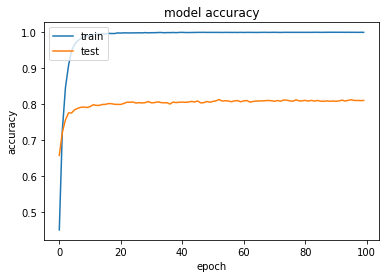

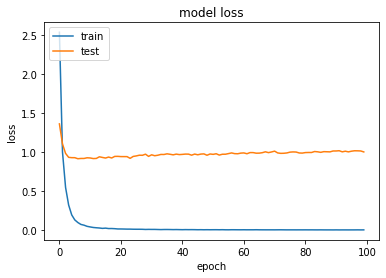

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

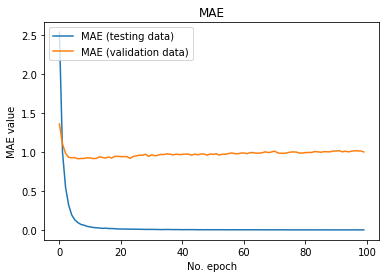

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

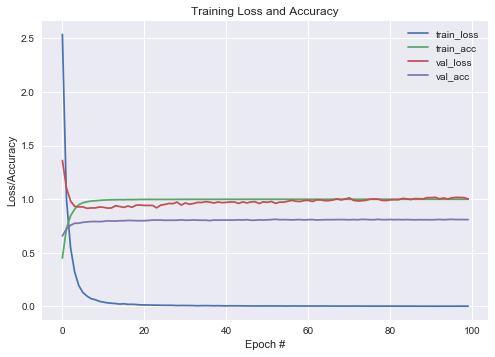

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()